---
# 特征提取

### k-means聚类

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import os, sys
from scipy.stats.mstats import winsorize
import seaborn as sns
import sklearn
from sklearn.feature_selection import mutual_info_classif

plt.rcParams["font.sans-serif"] = "Times New Roman"
import warnings

warnings.filterwarnings("ignore")


# 禁止函数内部输出
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


# 读取数据
train_data = pd.read_csv(r"Dataset/cs-training.csv", index_col="Unnamed: 0")
test_data = pd.read_csv(r"Dataset/cs-test.csv", index_col="Unnamed: 0")
column_names = ["Default", "Balance_r", "Age", "Worse_1m", "Debt_r", "Income", "Credit_num", "Worse_3m", "Estate_num",
                "Worse_2m", "Family_num"]
train_data.columns = column_names
test_data.columns = column_names
# 数据预处理

## 缺失值与异常值
# null检验
null_data = pd.DataFrame(pd.isna(train_data).sum(), columns=["Null_num"])
null_data["Null_percentage"] = null_data.Null_num / (train_data.count() + null_data.Null_num)
null_data.Null_percentage = null_data.Null_percentage.apply(lambda x: format(x, ".2%"))
null_data

# 数据特征 summary
train_data.describe().round(2).T
### Balance_r

train_data = train_data[~(train_data["Balance_r"] > 1)]
### 不考虑未成年人的信用

train_data = train_data[~(train_data["Age"] < 20)]

## Outlier 离群值



# 箱型图
def box_view(name):
    plt.figure(figsize=(10, 2))
    sns.boxplot(data=train_data, x=name)
    plt.title(name, size=14)
    plt.show()




# 计算偏度
skew = train_data.skew().sort_values(ascending=False)
skew_df = pd.DataFrame({'skew': skew})

# 将偏度大于10的进行对数变换
skew_index = skew_df[skew_df > 10].dropna().index
log_data = np.log(train_data[skew_index] + 1)
skew_log = log_data.skew().sort_values(ascending=False)
skew_log = pd.DataFrame({'skew': skew_log})
# sns.displot(log_data.Income)
# plt.title("Distribution of log-Income", size=12)


# 得到对数变换后的data, 再次summary并画出箱型图
train_data1 = train_data.copy()
train_data1[skew_index] = log_data
train_data1.describe().round(3).T
# 进行99%的winsorize缩尾处理
for name in column_names:
    train_data1[name] = winsorize(train_data1[name], limits=[0.005, 0.005])




train_data1.describe().round(3).T

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146678 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Default     146678 non-null  int64  
 1   Balance_r   146678 non-null  float64
 2   Age         146678 non-null  int64  
 3   Worse_1m    146678 non-null  int64  
 4   Debt_r      146678 non-null  float64
 5   Income      117495 non-null  float64
 6   Credit_num  146678 non-null  int64  
 7   Worse_3m    146678 non-null  int64  
 8   Estate_num  146678 non-null  int64  
 9   Worse_2m    146678 non-null  int64  
 10  Family_num  142815 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 13.4 MB


In [4]:
from sklearn.cluster import KMeans

In [5]:

# data1=train_data['Balance_r']
# data2=train_data['Income']
# data1=np.array(data1)
# data2=np.array(data2)
# DATA=np.vstack((data1,data2)).T
# DATA

column_names = ["Default", "Balance_r", "Age", "Worse_1m", "Debt_r", "Income", "Credit_num", "Worse_3m", "Estate_num",
                "Worse_2m", "Family_num"]
column_names.remove('Default')
data=train_data[column_names]

data=data.dropna()

from sklearn.preprocessing import MinMaxScaler
preprocess = MinMaxScaler()
data=pd.DataFrame(preprocess.fit_transform(data))

data


,0,1,2,3,4,5,6,7,8,9
0,0.766127,0.292683,0.020408,1.314070e-05,0.003031,0.224138,0.000000,0.111111,0.0,0.10
1,0.957151,0.231707,0.000000,1.994488e-06,0.000864,0.068966,0.000000,0.000000,0.0,0.05
2,0.658180,0.207317,0.010204,1.392869e-06,0.001011,0.034483,0.010204,0.000000,0.0,0.00
3,0.233810,0.109756,0.000000,5.899484e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00
4,0.907239,0.341463,0.010204,4.079058e-07,0.021134,0.120690,0.000000,0.018519,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
117490,0.385742,0.353659,0.000000,6.616200e-06,0.001130,0.120690,0.000000,0.000000,0.0,0.00
117491,0.040674,0.646341,0.000000,3.684238e-06,0.000698,0.068966,0.000000,0.018519,0.0,0.00
117492,0.299745,0.280488,0.000000,1.172645e-05,0.001856,0.068966,0.000000,0.018519,0.0,0.10
117493,0.000000,0.109756,0.000000,0.000000e+00,0.001900,0.068966,0.000000,0.000000,0.0,0.00


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117495 entries, 0 to 117494
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       117495 non-null  float64
 1   1       117495 non-null  float64
 2   2       117495 non-null  float64
 3   3       117495 non-null  float64
 4   4       117495 non-null  float64
 5   5       117495 non-null  float64
 6   6       117495 non-null  float64
 7   7       117495 non-null  float64
 8   8       117495 non-null  float64
 9   9       117495 non-null  float64
dtypes: float64(10)
memory usage: 9.0 MB


In [15]:
model=KMeans(n_clusters=4)
model.fit(data)
labels=model.labels_

In [25]:
r = pd.concat([data, pd.Series(model.labels_, index=data.index)], axis=1)
r.columns = list(data.columns) + [u'label']
r

,0,1,2,3,4,5,6,7,8,9,label
0,0.766127,0.292683,0.020408,1.314070e-05,0.003031,0.224138,0.000000,0.111111,0.0,0.10,1
1,0.957151,0.231707,0.000000,1.994488e-06,0.000864,0.068966,0.000000,0.000000,0.0,0.05,1
2,0.658180,0.207317,0.010204,1.392869e-06,0.001011,0.034483,0.010204,0.000000,0.0,0.00,1
3,0.233810,0.109756,0.000000,5.899484e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00,0
4,0.907239,0.341463,0.010204,4.079058e-07,0.021134,0.120690,0.000000,0.018519,0.0,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
117490,0.385742,0.353659,0.000000,6.616200e-06,0.001130,0.120690,0.000000,0.000000,0.0,0.00,2
117491,0.040674,0.646341,0.000000,3.684238e-06,0.000698,0.068966,0.000000,0.018519,0.0,0.00,3
117492,0.299745,0.280488,0.000000,1.172645e-05,0.001856,0.068966,0.000000,0.018519,0.0,0.10,2
117493,0.000000,0.109756,0.000000,0.000000e+00,0.001900,0.068966,0.000000,0.000000,0.0,0.00,0


In [18]:
import collections
data_count2=collections.Counter(labels)
data_count2

Counter({1: 22242, 0: 36182, 3: 35615, 2: 23456})

In [22]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(r)

(117495, 2)

Text(0.5,1,'UMAP projection of the dataset')

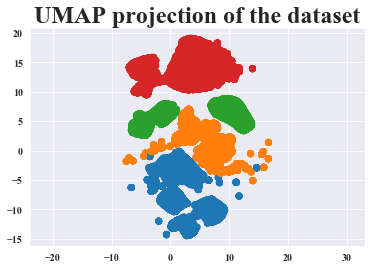

In [24]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in r.label])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the dataset', fontsize=24)

In [ ]:
# from sklearn.manifold import TSNE
#
# t_sne = TSNE()
#
# t_sne.fit(d)
# t_sne = pd.DataFrame(t_sne.embedding_, index=data.index)

In [ ]:
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False
# dd = t_sne[r[u'聚类类别'] == 0]
# plt.plot(dd[0], dd[1], 'r.')
# dd = t_sne[r[u'聚类类别'] == 1]
# plt.plot(dd[0], dd[1], 'go')
# dd = t_sne[r[u'聚类类别'] == 2]
# plt.plot(dd[0], dd[1], 'b*')
# dd = t_sne[r[u'聚类类别'] == 3]
# plt.plot(dd[0], dd[1], 'o')
# # plt.savefig(png_file)
# plt.clf()